In [1]:
#Set up project root to enable src/ imports

import sys
import os

PROJECT_ROOT = os.path.abspath("..")
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

print("Project root added:", PROJECT_ROOT)


Project root added: C:\Users\Dell\Desktop\clinical-uncertainty-ml


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from src.data_loader import preprocess_patient, create_sequences
from src.model import LSTMModel
from src.train import train_model
from src.uncertainty import mc_dropout_predict
from src.evaluate import evaluate
from sklearn.metrics import roc_auc_score, average_precision_score


In [4]:
#global seed added
import random
np.random.seed(42)
random.seed(42)


In [5]:
# Load preprocessed clinical time-series dataset

df = pd.read_csv("../data/raw/Dataset.csv")
print(df.shape)
df.head()


(1552210, 44)


,Unnamed: 0,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,...,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,Patient_ID
0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,1,0,17072
1,1,1,65.0,100.0,NaN,NaN,72.0,NaN,16.5,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,2,0,17072
2,2,2,78.0,100.0,NaN,NaN,42.5,NaN,NaN,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,3,0,17072
3,3,3,73.0,100.0,NaN,NaN,NaN,NaN,17.0,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,4,0,17072
4,4,4,70.0,100.0,NaN,129.0,74.0,69.0,14.0,NaN,...,NaN,330.0,68.54,0,NaN,NaN,-0.02,5,0,17072


In [6]:
df.columns.tolist()


['Unnamed: 0',
 'Hour',
 'HR',
 'O2Sat',
 'Temp',
 'SBP',
 'MAP',
 'DBP',
 'Resp',
 'EtCO2',
 'BaseExcess',
 'HCO3',
 'FiO2',
 'pH',
 'PaCO2',
 'SaO2',
 'AST',
 'BUN',
 'Alkalinephos',
 'Calcium',
 'Chloride',
 'Creatinine',
 'Bilirubin_direct',
 'Glucose',
 'Lactate',
 'Magnesium',
 'Phosphate',
 'Potassium',
 'Bilirubin_total',
 'TroponinI',
 'Hct',
 'Hgb',
 'PTT',
 'WBC',
 'Fibrinogen',
 'Platelets',
 'Age',
 'Gender',
 'Unit1',
 'Unit2',
 'HospAdmTime',
 'ICULOS',
 'SepsisLabel',
 'Patient_ID']

In [7]:
#Feature & Label Definition
FEATURES = ["HR", "O2Sat", "Temp", "SBP", "DBP", "MAP", "Resp"]
LABEL = "SepsisLabel"


In [8]:
# this was based on the entire dataset 
X_all, y_all = [], []

for pid, patient_df in df.groupby("Patient_ID"):
    X, y = preprocess_patient(patient_df, FEATURES, LABEL)

    if len(X) < 40:
        continue

    Xs, ys = create_sequences(X, y, seq_len=24, pred_horizon=6)
    X_all.append(Xs)
    y_all.append(ys)

X_all = np.concatenate(X_all)
y_all = np.concatenate(y_all)

print("X shape:", X_all.shape)
print("y shape:", y_all.shape)
print("Positive rate:", y_all.mean())


X shape: (430091, 24, 7)
y shape: (430091,)
Positive rate: 0.028603249079845895


In [9]:
# Subsample for faster experimentation based on entire dataset
np.random.seed(42)
idx = np.random.choice(len(X_all), size=50000, replace=False)

X_sub = X_all[idx]
y_sub = y_all[idx]

print(X_sub.shape, y_sub.shape)


(50000, 24, 7) (50000,)


In [10]:
model = LSTMModel(input_dim=len(FEATURES))
train_model(model, X_sub, y_sub, epochs=10)


Epoch 1/10, Loss: 0.1382
Epoch 2/10, Loss: 0.1288
Epoch 3/10, Loss: 0.1288
Epoch 4/10, Loss: 0.1284
Epoch 5/10, Loss: 0.1292
Epoch 6/10, Loss: 0.1288
Epoch 7/10, Loss: 0.1283
Epoch 8/10, Loss: 0.1272
Epoch 9/10, Loss: 0.1273
Epoch 10/10, Loss: 0.1275


In [11]:
mean_pred, uncertainty = mc_dropout_predict(model, X_sub, n_samples=30)

print("Mean uncertainty:", uncertainty.mean())
print("Max uncertainty:", uncertainty.max())


Mean uncertainty: 8.077612e-05
Max uncertainty: 0.00040775293


In [12]:
metrics = evaluate(y_sub, mean_pred.squeeze())
metrics


{'AUROC': 0.5702452179241704, 'AUPRC': 0.035555276723732314}

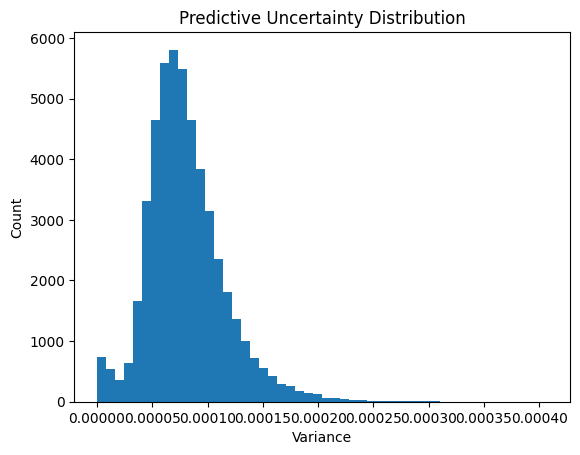

In [13]:
plt.hist(uncertainty, bins=50)
plt.title("Predictive Uncertainty Distribution")
plt.xlabel("Variance")
plt.ylabel("Count")
plt.show()


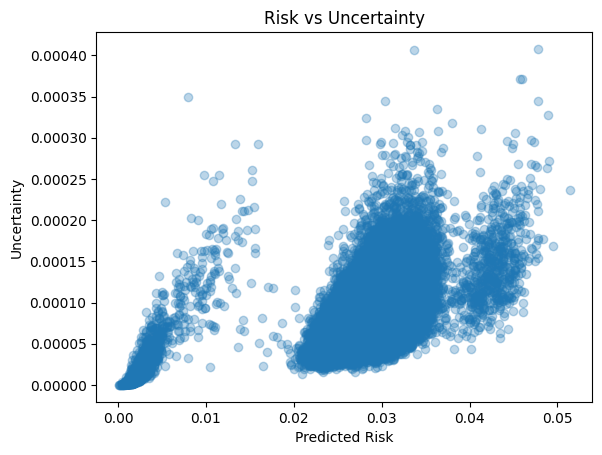

In [14]:
plt.scatter(mean_pred, uncertainty, alpha=0.3)
plt.xlabel("Predicted Risk")
plt.ylabel("Uncertainty")
plt.title("Risk vs Uncertainty")
plt.show()


In [15]:

patient_ids = df["Patient_ID"].unique()
print("Total patients:", len(patient_ids))


Total patients: 40336


In [16]:
#Train / Test Split (Patient-wise)
from sklearn.model_selection import train_test_split

train_patients, test_patients = train_test_split(
    patient_ids,
    test_size=0.2,
    random_state=42
)

print("Train patients:", len(train_patients))
print("Test patients:", len(test_patients))


Train patients: 32268
Test patients: 8068


In [17]:
# Generate time-series sequences for each training patient

X_train, y_train = [], []

for pid in train_patients:
    patient_df = df[df["Patient_ID"] == pid]

    X, y = preprocess_patient(patient_df, FEATURES, LABEL)

    if len(X) < 40:
        continue

    Xs, ys = create_sequences(X, y, seq_len=24, pred_horizon=6)
    X_train.append(Xs)
    y_train.append(ys)

X_train = np.concatenate(X_train)
y_train = np.concatenate(y_train)

print("Train X:", X_train.shape)
print("Train y:", y_train.shape)
print("Train positive rate:", y_train.mean())


Train X: (344513, 24, 7)
Train y: (344513,)
Train positive rate: 0.028265987059994835


In [18]:
X_test, y_test = [], []

for pid in test_patients:
    patient_df = df[df["Patient_ID"] == pid]

    X, y = preprocess_patient(patient_df, FEATURES, LABEL)

    if len(X) < 40:
        continue

    Xs, ys = create_sequences(X, y, seq_len=24, pred_horizon=6)
    X_test.append(Xs)
    y_test.append(ys)

X_test = np.concatenate(X_test)
y_test = np.concatenate(y_test)

print("Test X:", X_test.shape)
print("Test y:", y_test.shape)
print("Test positive rate:", y_test.mean())


Test X: (85578, 24, 7)
Test y: (85578,)
Test positive rate: 0.02996097127766482


In [19]:
# Subsample training data for computational efficiency

np.random.seed(42)

if len(X_train) > 50000:
    idx = np.random.choice(len(X_train), size=50000, replace=False)
    X_train = X_train[idx]
    y_train = y_train[idx]

print("Final Train X:", X_train.shape)


Final Train X: (50000, 24, 7)


In [20]:
#Model Definition & Training
model = LSTMModel(input_dim=len(FEATURES))
train_model(model, X_train, y_train, epochs=10)


Epoch 1/10, Loss: 0.1370
Epoch 2/10, Loss: 0.1254
Epoch 3/10, Loss: 0.1263
Epoch 4/10, Loss: 0.1268
Epoch 5/10, Loss: 0.1251
Epoch 6/10, Loss: 0.1253
Epoch 7/10, Loss: 0.1241
Epoch 8/10, Loss: 0.1235
Epoch 9/10, Loss: 0.1241
Epoch 10/10, Loss: 0.1243


In [21]:
#MC Dropout Prediction
mean_pred_test, uncertainty_test = mc_dropout_predict(
    model, X_test, n_samples=30
)

baseline_metrics = evaluate(y_test, mean_pred_test.squeeze()) # this line is exploratory
baseline_metrics 


{'AUROC': 0.5955961763418136, 'AUPRC': 0.0403554422480028}

In [22]:
# FORCE all arrays to 1D (CRITICAL FIX)
y_true = y_test.astype(int)

y_prob = mean_pred_test.reshape(-1)
uncertainty = uncertainty_test.reshape(-1)

print("Shapes check:")
print("y_true:", y_true.shape)
print("y_prob:", y_prob.shape)
print("uncertainty:", uncertainty.shape)


Shapes check:
y_true: (85578,)
y_prob: (85578,)
uncertainty: (85578,)


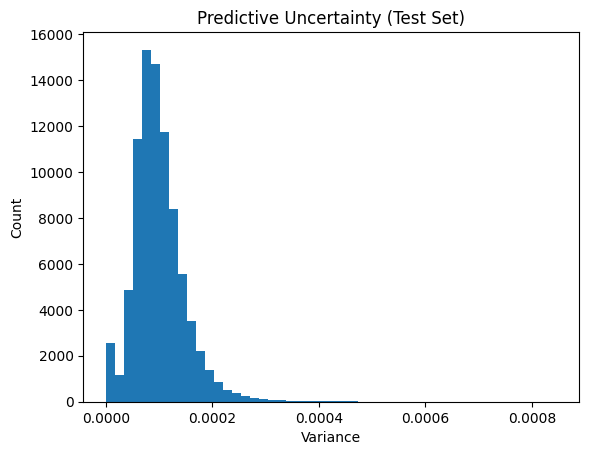

In [23]:
#Uncertainty Distribution Plot
import matplotlib.pyplot as plt

plt.hist(uncertainty_test, bins=50)
plt.title("Predictive Uncertainty (Test Set)")
plt.xlabel("Variance")
plt.ylabel("Count")
plt.show()


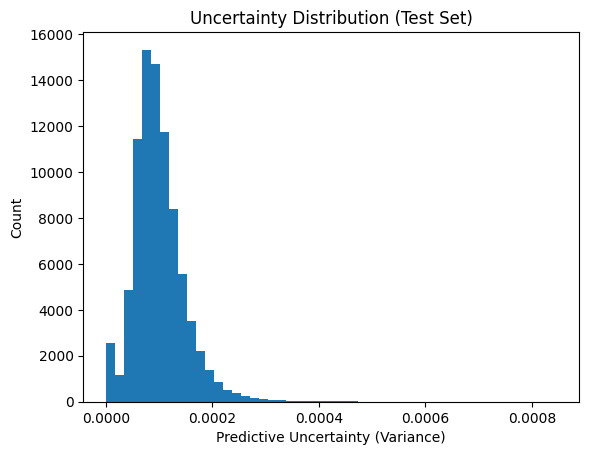

In [24]:
import matplotlib.pyplot as plt

plt.hist(uncertainty_test, bins=50)
plt.xlabel("Predictive Uncertainty (Variance)")
plt.ylabel("Count")
plt.title("Uncertainty Distribution (Test Set)")
plt.show()


In [25]:
#Uncertainty Threshold Definition
thresholds = np.percentile(
    uncertainty_test,
    [10, 25, 50, 75]
)

thresholds


array([5.07049052e-05, 6.93151196e-05, 9.28147929e-05, 1.22590223e-04])

In [26]:
y_true = y_test.astype(int)

y_prob = mean_pred_test.reshape(-1)      # FORCE 1D
uncertainty = uncertainty_test.reshape(-1)

print(y_true.shape, y_prob.shape, uncertainty.shape)


(85578,) (85578,) (85578,)


In [27]:
def evaluate_with_uncertainty_filter(
    y_true, y_prob, uncertainty, threshold
):
    mask = uncertainty <= threshold

    if mask.sum() < 100:
        return None

    y_true_f = y_true[mask]
    y_prob_f = y_prob[mask]

    auroc = roc_auc_score(y_true_f, y_prob_f)
    auprc = average_precision_score(y_true_f, y_prob_f)

    coverage = mask.mean()

    return {
        "AUROC": auroc,
        "AUPRC": auprc,
        "Coverage": coverage
    }


In [28]:
#Run Filtering Experiments
results = []

for t in thresholds:
    res = evaluate_with_uncertainty_filter(
        y_true,
        y_prob,
        uncertainty,
        t
    )
    if res:
        res["Uncertainty_Threshold"] = t
        results.append(res)

results


[{'AUROC': 0.7376550900541416,
  'AUPRC': 0.02739056791464333,
  'Coverage': np.float64(0.10000233704924162),
  'Uncertainty_Threshold': np.float64(5.0704905152088035e-05)},
 {'AUROC': 0.6506591813939953,
  'AUPRC': 0.040883188916969,
  'Coverage': np.float64(0.25000584262310405),
  'Uncertainty_Threshold': np.float64(6.931511961738579e-05)},
 {'AUROC': 0.6164232435333807,
  'AUPRC': 0.037916207964795196,
  'Coverage': np.float64(0.5),
  'Uncertainty_Threshold': np.float64(9.28147928789258e-05)},
 {'AUROC': 0.6023095192994216,
  'AUPRC': 0.0378903264759641,
  'Coverage': np.float64(0.7499941573768959),
  'Uncertainty_Threshold': np.float64(0.0001225902233272791)}]

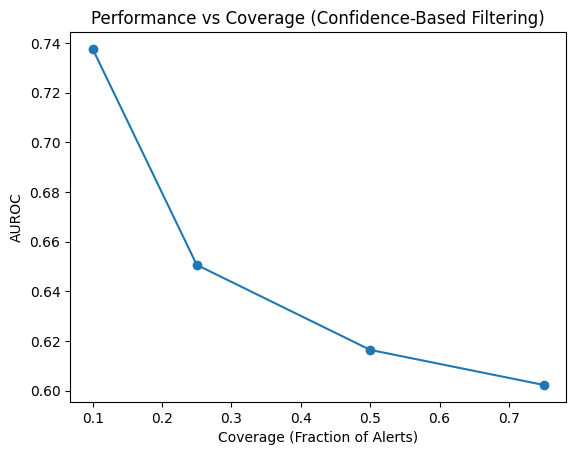

In [29]:
#Performance vs Coverage Plot
coverages = [r["Coverage"] for r in results]
aurocs = [r["AUROC"] for r in results]

plt.plot(coverages, aurocs, marker="o")
plt.xlabel("Coverage (Fraction of Alerts)")
plt.ylabel("AUROC")
plt.title("Performance vs Coverage (Confidence-Based Filtering)")
plt.show()


In [30]:
#Results Table
results_df = pd.DataFrame(results)
results_df.round(4)


,AUROC,AUPRC,Coverage,Uncertainty_Threshold
0,0.7377,0.0274,0.10,0.0001
1,0.6507,0.0409,0.25,0.0001
2,0.6164,0.0379,0.50,0.0001
3,0.6023,0.0379,0.75,0.0001
